In [12]:
%pip install pandas numpy scikit-learn matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.


In [14]:
# --- 1. Load SMS Dataset (from sms folder) ---
try:
    print("📂 Loading SMS files...")
    # Load all three SMS files
    df_train = pd.read_csv("train.csv")
    df_test = pd.read_csv("test.csv")
    df_valid = pd.read_csv("valid.csv")
    
    # Combine them into one SMS dataframe
    df_sms = pd.concat([df_train, df_test, df_valid], ignore_index=True)
    
    # Clean SMS Data
    # Convert 'ham' -> 0 and 'spam' -> 1
    # Note: If your CSV has numeric labels already, this map won't break anything
    if df_sms['label'].dtype == 'object':
        df_sms['label'] = df_sms['label'].map({'ham': 0, 'spam': 1})
        
    df_sms = df_sms[['text', 'label']]
    print(f"   -> Loaded {len(df_sms)} SMS messages.")

except Exception as e:
    print(f"❌ Error loading SMS files: {e}")
    df_sms = pd.DataFrame()


# --- 2. Load Email Dataset (phishing_email.jsonl) ---
try:
    print("📂 Loading Email JSONL file...")
    # Read JSONL file
    df_email = pd.read_json("phishing_email.jsonl", lines=True)
    
    # Clean Email Data
    # The JSONL usually has 'prompt' (the email text) and 'label'
    if 'prompt' in df_email.columns:
        df_email = df_email.rename(columns={'prompt': 'text'})
    
    df_email = df_email[['text', 'label']]
    print(f"   -> Loaded {len(df_email)} Emails.")

except Exception as e:
    print(f"❌ Error loading Email file: {e}")
    df_email = pd.DataFrame()


# --- 3. Merge Datasets ---
df_final = pd.concat([df_sms, df_email], ignore_index=True)

# Drop any rows that might be missing data
df_final.dropna(subset=['text', 'label'], inplace=True)
df_final['label'] = df_final['label'].astype(int) # Ensure labels are integers

print("\n✅ DATA LOADING COMPLETE")
print(f"Total Combined Samples: {len(df_final)}")
display(df_final.head())

📂 Loading SMS files...
   -> Loaded 5572 SMS messages.
📂 Loading Email JSONL file...
   -> Loaded 200 Emails.

✅ DATA LOADING COMPLETE
Total Combined Samples: 5772


,text,label
0,Ok Chinese food on its way. When I get fat you...,0
1,Haha... Yup hopefully we will lose a few kg b...,0
2,URGENT! You have won a 1 week FREE membership ...,1
3,Host-based IDPS for linux systems.,0
4,Did you try making another butt.,0


📊 DATASET STATISTICS
----------------------
Total Rows:     5772
Safe (Ham):     4925 (85.3%)
Phishing/Spam:  847 (14.7%)


C:\Users\Software Engineer\AppData\Local\Temp\ipykernel_15292\1321252961.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df_final, palette=['#66b3ff', '#ff9999'])


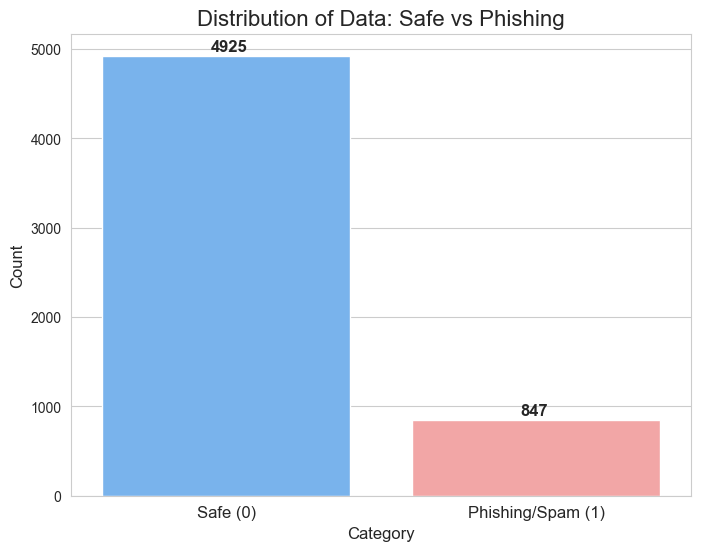

In [15]:
# --- Calculate Statistics ---
total_count = len(df_final)
safe_count = len(df_final[df_final['label'] == 0])
phishing_count = len(df_final[df_final['label'] == 1])

print(f"📊 DATASET STATISTICS")
print(f"----------------------")
print(f"Total Rows:     {total_count}")
print(f"Safe (Ham):     {safe_count} ({(safe_count/total_count)*100:.1f}%)")
print(f"Phishing/Spam:  {phishing_count} ({(phishing_count/total_count)*100:.1f}%)")

# --- Plot Graph ---
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=df_final, palette=['#66b3ff', '#ff9999'])

plt.title('Distribution of Data: Safe vs Phishing', fontsize=16)
plt.xticks([0, 1], ['Safe (0)', 'Phishing/Spam (1)'], fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)

# Add numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + 0.35, p.get_height() + 50),
                fontsize=12, fontweight='bold')

plt.show()

In [16]:
# --- IMPROVEMENT 1: Better Cleaning Function ---
import re

def clean_text(text):
    text = str(text).lower()
    # Replace URLs with a special token so model knows a link exists
    text = re.sub(r'http\S+', ' http_link ', text)
    text = re.sub(r'www\S+', ' http_link ', text)
    # Keep exclamation marks! They are important for urgency.
    text = re.sub(r'[^a-z0-9!? ]', '', text)
    return text

# Apply cleaning
print("🧹 Cleaning text data...")
df_final['clean_text'] = df_final['text'].apply(clean_text)

# --- IMPROVEMENT 2: Advanced Pipeline ---
print("⚙️ Training Improved Model...")

X_train, X_test, y_train, y_test = train_test_split(
    df_final['clean_text'], 
    df_final['label'], 
    test_size=0.2, 
    random_state=42,
    stratify=df_final['label']
)

pipeline = Pipeline([
    # TF-IDF Changes:
    # ngram_range=(1, 2) -> Looks at "urgent" AND "urgent action"
    # min_df=2 -> Ignores words that only appear once (typos)
    ('tfidf', TfidfVectorizer(
        stop_words='english', 
        max_features=10000, 
        ngram_range=(1, 2), 
        min_df=2
    )),
    
    # Random Forest Changes:
    # class_weight='balanced' -> Fixes the bias towards Safe messages
    # n_estimators=200 -> More trees = more accuracy
    ('rf', RandomForestClassifier(
        n_estimators=200, 
        class_weight='balanced', 
        random_state=42, 
        n_jobs=-1
    ))
])

pipeline.fit(X_train, y_train)
print("✅ Improved Training Finished!")

🧹 Cleaning text data...
⚙️ Training Improved Model...
✅ Improved Training Finished!


🏆 MODEL ACCURACY: 0.9749 (97.49%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Safe       0.98      0.99      0.99       986
    Phishing       0.96      0.86      0.91       169

    accuracy                           0.97      1155
   macro avg       0.97      0.93      0.95      1155
weighted avg       0.97      0.97      0.97      1155



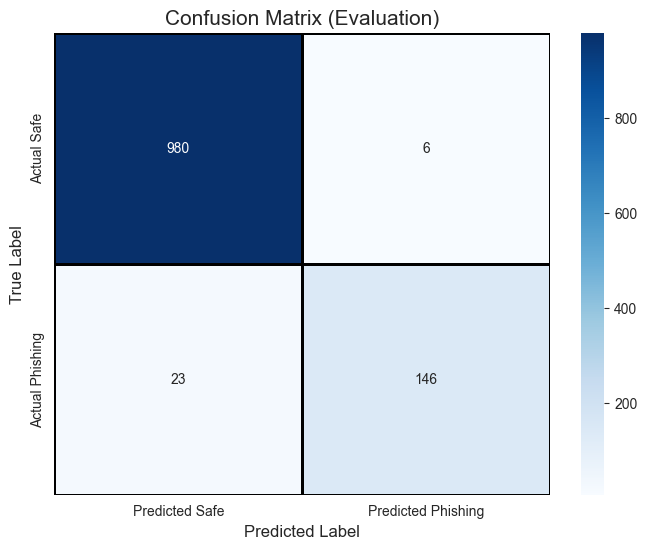

In [17]:
# Make Predictions
y_pred = pipeline.predict(X_test)

# --- Accuracy Score ---
acc = accuracy_score(y_test, y_pred)
print(f"🏆 MODEL ACCURACY: {acc:.4f} ({acc*100:.2f}%)")
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Safe', 'Phishing']))

# --- Confusion Matrix Graph ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black',
            xticklabels=['Predicted Safe', 'Predicted Phishing'],
            yticklabels=['Actual Safe', 'Actual Phishing'])

plt.title('Confusion Matrix (Evaluation)', fontsize=15)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [18]:
def detect_phishing(text):
    # Clean the input exactly like the training data
    cleaned_input = clean_text(text)
    
    prediction = pipeline.predict([cleaned_input])[0]
    proba = pipeline.predict_proba([cleaned_input])[0]
    
    if prediction == 1:
        result = "🚨 PHISHING DETECTED"
        color = "\033[91m" 
        confidence = proba[1]
    else:
        result = "✅ SAFE MESSAGE"
        color = "\033[92m" 
        confidence = proba[0]
    
    reset = "\033[0m"
    print(f"Input: '{text}'")
    print(f"Analysis: {color}{result}{reset}")
    print(f"Confidence: {confidence:.2%}")
    print("-" * 50)

# Re-running your examples
detect_phishing("Hey, can we meet for coffee tomorrow?")
detect_phishing("URGENT! Your account is compromised. Click here to reset password: http://bit.ly/fake")
detect_phishing("Congratulations! You've won a $500 gift card. Call now!")

Input: 'Hey, can we meet for coffee tomorrow?'
Analysis: ✅ SAFE MESSAGE
Confidence: 100.00%
--------------------------------------------------
Input: 'URGENT! Your account is compromised. Click here to reset password: http://bit.ly/fake'
Analysis: 🚨 PHISHING DETECTED
Confidence: 73.97%
--------------------------------------------------
Input: 'Congratulations! You've won a $500 gift card. Call now!'
Analysis: 🚨 PHISHING DETECTED
Confidence: 69.53%
--------------------------------------------------


In [19]:
import joblib

# Define the filename
model_filename = "phishing_model.pkl"

# Save the entire pipeline (Vectorizer + Random Forest)
joblib.dump(pipeline, model_filename)

print(f"✅ Model successfully saved to: {model_filename}")

✅ Model successfully saved to: phishing_model.pkl


In [20]:
# Load the model from the file
loaded_model = joblib.load("phishing_model.pkl")

print("📂 Model loaded from disk.")

# Test it with a new message
test_msg = "URGENT! Your account is locked. Click here."
prediction = loaded_model.predict([test_msg])[0]

if prediction == 1:
    print(f"Test Prediction: PHISHING (It works!)")
else:
    print(f"Test Prediction: SAFE (It works!)")

📂 Model loaded from disk.
Test Prediction: SAFE (It works!)
